In [2]:
import numpy as np
from scipy.io import wavfile
import matplotlib.pyplot as plt
import os
from tqdm import tqdm


from enfify.preprocessing import downsample_ffmpeg, bandpass_filter, list_files_in_directory
from enfify.enf_estimation import segmented_phase_estimation_DFT0
from enfify.rodriguez_audio_authenticity import feature, Lambda, lambda_accuracy

In [3]:
# 1min Audio files
input_dir = '/home/leo_dacasi/Dokumente/summerofcode/Enfify Data Synced/interim/ENF-WHU-Dataset/1min_ref/1min_enf_ref_data'
output_dir = '/home/leo_dacasi/Dokumente/summerofcode/Enfify Data Synced/interim/ENF-WHU-Dataset/1min_ref/cut_1min_enf_ref_data'

file_list_uncut = os.listdir(input_dir)
file_list_cut = os.listdir(output_dir)
fs = 400

band_down_sig = []

for wav_file in file_list_uncut:
    file_path = os.path.join(input_dir, wav_file)
    fs, signal = wavfile.read(file_path)
    bandpass_sig = bandpass_filter(signal, 49.5, 50.5, 400, 1)
    band_down_sig.append(signal)

cut_band_down_sig = []
for wav_file in file_list_cut:
    file_path = os.path.join(output_dir, wav_file)
    fs, signal = wavfile.read(file_path)
    bandpass_sig = bandpass_filter(signal, 49.5, 50.5, 400, 1)
    cut_band_down_sig.append(signal)

In [5]:
N_DFT = 20_000
NUM_CYCLES = 10
F_uncut = []
F_cut = []

for sig in tqdm(band_down_sig):
    F = feature(segmented_phase_estimation_DFT0(sig, 400, NUM_CYCLES, N_DFT, 50))
    F_uncut.append(F)

for sig in tqdm(cut_band_down_sig):
    F = feature(segmented_phase_estimation_DFT0(sig, 400, NUM_CYCLES, N_DFT, 50))
    F_cut.append(F)

100%|██████████| 130/130 [00:51<00:00,  2.54it/s]


Characterization probaility: 93.07692307692308%


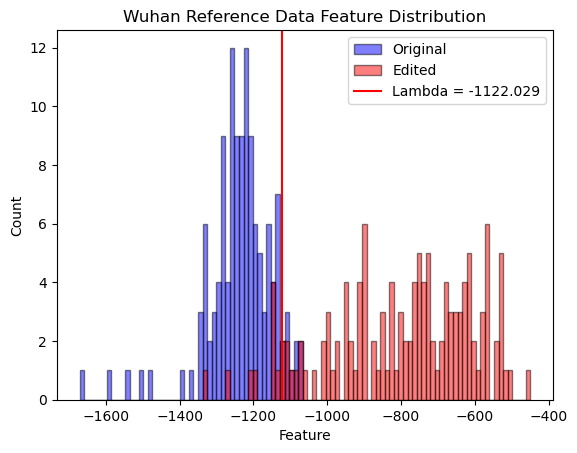

In [6]:
num_samples = len(band_down_sig)
labels = np.concatenate([np.zeros(num_samples), np.ones(num_samples)])
features = np.concatenate([F_uncut, F_cut])

min_val = np.min(features)
max_val = np.max(features)
bins = np.linspace(min_val, max_val,100)

LAMBDA = Lambda(F_uncut, F_cut)
accuracy = lambda_accuracy(F_uncut, F_cut, LAMBDA)
print(f'Characterization probaility: {accuracy*100}%')

plt.hist(F_uncut, bins=bins,color='blue', alpha=0.5, edgecolor='black',label="Original")
plt.hist(F_cut, bins=bins, color='red', alpha=0.5, edgecolor='black', label="Edited")
plt.xlabel("Feature")
plt.ylabel("Count")
plt.title("Wuhan Reference Data Feature Distribution")
plt.axvline(LAMBDA, color="red", label=f"Lambda = {LAMBDA:.3f}")
plt.legend(loc="best")
#plt.savefig("Wuhan_ref_feature_distribution.pdf")
plt.show()